In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
COLAB = False

**Environment setup if on collab**

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    %cd drive/MyDrive/COMP9444 

**Imports**

In [7]:
import librosa
import matplotlib.pylab as plt
import numpy as np
import json
import librosa.display
import pandas as pd
import glob
import os
import audioread
import h5py

# Obtain Top 8 genres

In [8]:
base_path = "fma_metadata/"

genres =  pd.read_csv(base_path+'genres.csv')
tracks = pd.read_csv(base_path+'tracks.csv', header=[0,1],index_col = 0)
features = pd.read_csv(base_path+'features.csv',header = [0,1,2],index_col = 0)

In [ ]:
print(genres.columns.values)

     genre_id  #tracks  parent          title  top_level
31         38    38154       0   Experimental         38
14         15    34413       0     Electronic         15
11         12    32923       0           Rock         12
162      1235    14938       0   Instrumental       1235
9          10    13845       0            Pop         10
16         17    12706       0           Folk         17
20         21     8389       0        Hip-Hop         21
1           2     5271       0  International          2


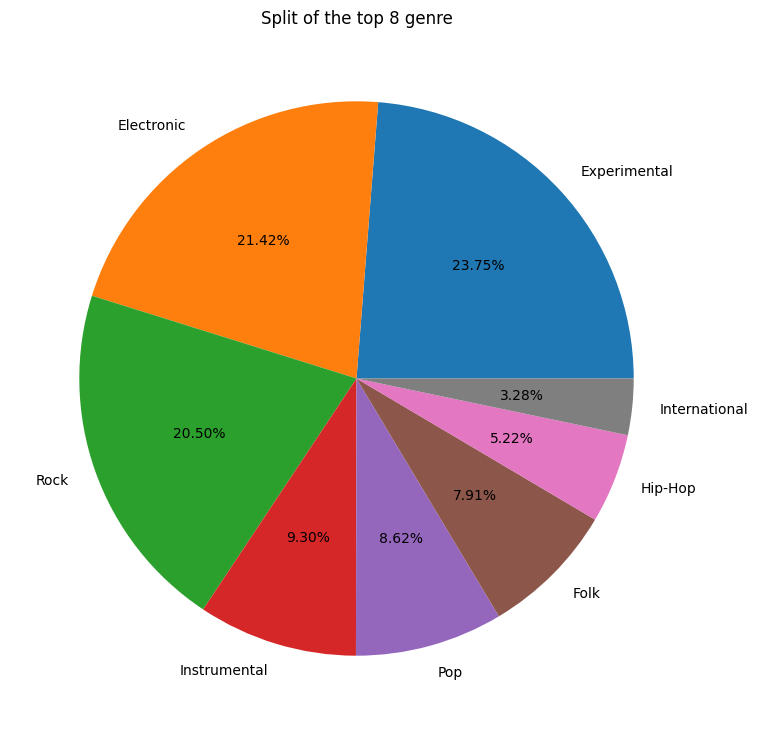

In [9]:
top_level_genre = genres.loc[genres['genre_id'] == genres['top_level']]
sorted_genre = top_level_genre.sort_values('#tracks',ascending = False)
top_genre = sorted_genre.head(8)
print(top_genre)
top_genre_id = top_genre["genre_id"]
top_genre_title = top_genre["title"]
plt.rcParams["figure.figsize"] = (9,9)
plt.pie(top_genre["#tracks"], labels=top_genre["title"], autopct='%.2f%%')
plt.title("Split of the top 8 genre")
plt.show()
# print(img_id)

# Features Considered
**chroma_cens**-> Chroma Energy Normalised Statistics(CENS),  CENS features is that taking statistics over large windows smooths local deviations in tempo, articulation, and musical ornaments such as trills and arpeggiated chords.

**chroma_cqt**->

**chroma_stft**->

**mfcc**->

**rmse**->

**spectral_centroid**->

**spectral_contrast**->

**spectral_rolloff**->

**tonnetz**->

**zcr**->zero crossing rate, calculates the the number of times the signal changes value, from positive to negative and vice versa, divided by the length of the frame measures noiseness of a signal

**Preprocess**

In [11]:
'''
Plotting waveform of the audio
'''
def base_plot(x,sr,title):
    plt.figure(figsize=(14, 8))
    librosa.display.waveshow(x, sr=sr)
    plt.title(title)
    # plt.ylim([1,-1])
    return plt

'''
Fourier Transform
'''
def calc_mag_freq(x,sr):
    magnitude = np.abs(np.fft.fft(x))
    freqeuncy = np.linspace(0,sr,len(magnitude))

    return magnitude,freqeuncy

def fft(x,sr):
    magnitude,frequency = calc_mag_freq(x,sr)
    plt.figure(figsize=(14, 8))
    librosa.display.waveshow(x,sr=sr)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Fourier Transform Plot")
    return plt

'''
mel_SPectrogram
'''
def mel_spec(x,sr):
    spect = librosa.feature.melspectrogram(y=x, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect

'''
mfcc
'''
def mfcc(x,sr):
    spect = librosa.feature.melspectrogram(x, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect

def write_plot(f,dirpath,file_name):
  f.savefig(dirpath+"/"+file_name+".png")

Example plot of STFT

In [12]:
'''
Read and convert file into specgtrogram
'''
def read_convert_melspec(file_name,title = None):
  try:
    x,sr = librosa.load(file_name,sr = None)
  except:
    print(f"Can't read {file_name}")
    return None

  if title is None:
    title = file_name[:-4]
  return mel_spec(x,sr)

Use Example File to show the size of the melspectrogram output

In [17]:
audio_base_path = f"fma_small"
total_audio_list = []
mel_file = {}
for i in range(156):
  if i < 10:
    string = "00"+str(i)
  elif i < 100:
    string = "0"+str(i)
  else :
    string = str(i)
  list_file = glob.glob(f"{audio_base_path}/{string}/*.mp3")
  total_audio_list.extend(list_file)



**Obtain 1000 track list for each of the top 8 genres**

In [18]:
print(tracks.columns.values)
seperate_genre_dict = {}
for i in top_genre_title:
  seperate_genre_dict[i] = []

[('album', 'comments') ('album', 'date_created')
 ('album', 'date_released') ('album', 'engineer') ('album', 'favorites')
 ('album', 'id') ('album', 'information') ('album', 'listens')
 ('album', 'producer') ('album', 'tags') ('album', 'title')
 ('album', 'tracks') ('album', 'type') ('artist', 'active_year_begin')
 ('artist', 'active_year_end') ('artist', 'associated_labels')
 ('artist', 'bio') ('artist', 'comments') ('artist', 'date_created')
 ('artist', 'favorites') ('artist', 'id') ('artist', 'latitude')
 ('artist', 'location') ('artist', 'longitude') ('artist', 'members')
 ('artist', 'name') ('artist', 'related_projects') ('artist', 'tags')
 ('artist', 'website') ('artist', 'wikipedia_page') ('set', 'split')
 ('set', 'subset') ('track', 'bit_rate') ('track', 'comments')
 ('track', 'composer') ('track', 'date_created')
 ('track', 'date_recorded') ('track', 'duration') ('track', 'favorites')
 ('track', 'genre_top') ('track', 'genres') ('track', 'genres_all')
 ('track', 'information')

In [19]:
for i in total_audio_list:
  for j in seperate_genre_dict.keys():
    try:
      if tracks[('track', 'genre_top')][int(i[-10:-4].lstrip('0'))] == j:
        seperate_genre_dict[j].append(i)
        continue
    except Exception as e:
      print(f"Exception {e}and the string is {i}")
      break

In [115]:
print(seperate_genre_dict.keys())

dict_keys(['Experimental', 'Electronic', 'Rock', 'Instrumental', 'Pop', 'Folk', 'Hip-Hop', 'International'])


Convert to mel_spec and store as json file for each directory

In [81]:
'''
preprocess data and store in to a hdf5 file
'''
def write_genre_hdf(genre_list,genre_name):

  list_store = []
  for i in genre_list:
    converted = read_convert_melspec(i)
    if converted is None:
      continue
    temp = {"name":i,"mel_spec":converted}

    list_store.append(temp)

  file_name = "mel_spec/"+genre_name+".hdf5"
  print(file_name)
  print(len(list_store))
    

  #To get the shape to be Nx10x10, you could  use rollaxis:
  h = h5py.File(file_name, 'w')
  print(list_store[0].keys())
  group = h.create_group(genre_name)
  for item in list_store:

    group.create_dataset(item["name"].replace("/","-"),data = item["mel_spec"])
  h.close()
        

In [113]:
'''
Convert all to json file, there will be a file for each music genre
'''
for keys,values in list(seperate_genre_dict.items):
    write_genre_hdf(values,keys)

dict_keys(['Experimental', 'Electronic', 'Rock', 'Instrumental', 'Pop', 'Folk', 'Hip-Hop', 'International'])

In [114]:
''' 
Reading the data out,
return a list of dictionary
each dictionary contains the name and preprocessed data
'''
def read_hdf(file_path):
    return_dict = []
    with h5py.File(file_path, 'r') as hf:
        print(list(hf.keys()))
        dataset = hf[file_path[9:-5]]
        print(len(list(dataset.keys())))
        keys = list(dataset.keys())
        for i in keys:
            return_dict.append({
                "name":i.replace("-","/"),
                "data":dataset[i][:]
            })
        return return_dict